In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
import anndata
from sklearn.mixture import GaussianMixture
from fcsy import DataFrame
import matplotlib
from glob import glob
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42

# scanpy settings
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150, frameon=False, figsize=(4, 4)) 
sc._settings.ScanpyConfig.n_jobs=4

# readin the information table
sampleInfo = pd.read_excel(os.path.join('/Users/tan/preterm_DHA/data', 
                                        '210825_database_for_petter_sent_210826.xlsx'), 
                         dtype={'Inf_ID':str})
selectInfo = sampleInfo

#def subsample(data, label, n, sub_name):
#    # subsample the same number of cells per subpopulation
#    if sub_name in label['level1'].unique().tolist():
#        n_row = len(label[label['level1'] == sub_name])
#        df_label_sub = label[label['level1'] == sub_name].sample(n=min(n, n_row),
#                                                                 random_state=np.random.RandomState(0),
#                                                                 replace=False)
#    elif sub_name in label['level2'].unique().tolist():
#        n_row = len(label[label['level2'] == sub_name])
#        df_label_sub = label[label['level2'] == sub_name].sample(n=min(n, n_row),
#                                                                 random_state=np.random.RandomState(0),
#                                                                 replace=False)
#    elif sub_name == 'Treg':
#        n_row = len(label[label['level3'].isin(['CD39 Memory Tregs', 'Memory Tregs', 'Naive Tregs'])])
#        df_label_sub = label[label['level3'].isin(['CD39 Memory Tregs', 'Memory Tregs', 'Naive Tregs'])].sample(n=min(n, n_row),
#                                                                                                                random_state=np.random.RandomState(0),
#                                                                                                                replace=False)
#    else:
#        raise NameError("unknown sub pop")
#    df_data_sub = data.loc[df_label_sub.index]
#    return df_data_sub, df_label_sub

In [2]:
dataDir = '/Users/tan/cytof_data/*/renamed'
labelDir = '/Users/tan/cytof_data/*/classifiedV3'
#scale_info_path = '/Users/tan/preterm_DHA/data/scale_info_preterm_DHA.csv'
nsample = 1000
sub_name = 'NK-cells'
#need_scale_info = True
#if os.path.exists(scale_info_path):
#    need_scale_info = False

drop_dic = {'B-cells': ['CD33', 'CD3', 'TCRgd', 'Siglec-8', 'CD14', 'CD141', 'CD4'],
            'CD4 T': ['IgD', 'CD1c', 'TCRgd', 'Siglec-8', 'CD20', 'CD14'],
            'CD8 T': ['IgD', 'CD11c', 'CD1c', 'TCRgd', 'Siglec-8', 'CD20', 'CD14'],
            'Eosinophils': ['IgD', 'CD57', 'CD25', 'TCRgd', 'CD14'],
            'Monocytes': ['CD57', 'IgD', 'CD25', 'CD20', 'TCRgd', 'CD22', 'CD127'], 
            'Neutrophils': ['IgD', 'HLA-DR', 'CD57', 'CD25', 'CD22', 'TCRgd', 'CD123', 'CD161'],
            'NK-cells': []}

#dataTmp.drop(columns=['CD33', 'CD3', 'TCRgd', 'Siglec-8', 'CD14', 'CD141', 'CD4'], inplace=True) # B-cells
#dataTmp.drop(columns=['IgD', 'CD1c', 'TCRgd', 'Siglec-8', 'CD20', 'CD14'], inplace=True) #  'CD4 T'
#dataTmp.drop(columns=['IgD', 'CD11c', 'CD1c', 'TCRgd', 'Siglec-8', 'CD20', 'CD14'], inplace=True) # CD8 T
#dataTmp.drop(columns=['IgD', 'CD57', 'CD25', 'TCRgd', 'CD14'], inplace=True) # Eosinophils
#dataTmp.drop(columns=['CD57', 'IgD', 'CD25', 'CD20', 'TCRgd', 'CD22', 'CD127'], inplace=True) # Monocytes
#dataTmp.drop(columns=['IgD', 'HLA-DR', 'CD57', 'CD25', 'CD22', 'TCRgd', 'CD123', 'CD161'], inplace=True) # Neutrophils

# readin and merge the file according to "selectInfo" as an anndata object
#labelList = []
#dataList = []
all_data_path = 'adata/all_data_preterm_DHA.h5ad'
if not os.path.exists(all_data_path):
    print('adata not found, load and preprocess raw data...')
    all_data_list = []
    all_label_list = []
    for i in range(len(selectInfo)):
        label_path = glob(labelDir + '/*/' + str(selectInfo['ID_unique'].iloc[i]) + '.csv')[0]
        data_path = glob(dataDir + '/*/' + str(selectInfo['ID_unique'].iloc[i]) + '.fcs')[0]
        labelTmp = pd.read_csv(label_path)
        labelTmp['ID_unique'] = np.repeat(selectInfo['ID_unique'].iloc[i], len(labelTmp.index))
        labelTmp['timepoint'] = np.repeat(selectInfo['Timepoint_string'].iloc[i], len(labelTmp.index))
        labelTmp['Inf_ID'] = np.repeat(str(selectInfo['Inf_ID'].iloc[i]), len(labelTmp.index))
        labelTmp['PN_days'] = np.repeat(str(selectInfo['PN_days_sample'].iloc[i]), len(labelTmp.index))
        labelTmp['group'] = np.repeat(str(selectInfo['randtrt'].iloc[i]), len(labelTmp.index))
        labelTmp['timepoint_group'] = np.repeat(selectInfo['Timepoint_string'].iloc[i] + 
                                                '_' + 
                                                str(selectInfo['randtrt'].iloc[i]), len(labelTmp.index))
        labelTmp['batch'] = np.repeat(data_path.split('/')[-4], len(labelTmp.index)) #EXP-XX-XXXXXX
        dataTmp = DataFrame.from_fcs(data_path, channel_type='long')
        # filter the cells without a level1 tag
        dataTmp = dataTmp[labelTmp['level1']!=' ']
        labelTmp = labelTmp[labelTmp['level1']!=' ']
        # remove EQBeads and DNA channel # also remove the negative channels
        dataTmp.drop(columns=['Time', 'Event_length', 'Center', 'Offset', 'Width', 'Residual',
                               '102Pd', '104Pd', '105Pd', '106Pd', '108Pd', 
                               '116Cd', '131Xe', '133Cs', '191Ir', '193Ir'], inplace=True)
        dataTmp = np.arcsinh(dataTmp/5)
        #df_data_sub, df_label_sub = subsample(dataTmp, labelTmp, n, sub_name)
        # prepare the list
        #labelList.append(df_label_sub)
        #dataList.append(df_data_sub)
        #if need_scale_info:
        #    all_data_list.append(dataTmp)
        all_data_list.append(dataTmp)
        all_label_list.append(labelTmp)
    
    #data = pd.concat(dataList, ignore_index=True)
    #label = pd.concat(labelList, ignore_index=True)
    #if need_scale_info:
    #    all_data = pd.concat(all_data_list, ignore_index=True)
    #    df_scale_info = pd.DataFrame({'mean': np.mean(all_data, axis = 0),
    #                                  'std': np.std(all_data, axis = 0)})
    #    df_scale_info.to_csv(scale_info_path)
    all_data = pd.concat(all_data_list, ignore_index=True)
    all_label = pd.concat(all_label_list, ignore_index=True)
    adata = anndata.AnnData(all_data)
    adata.obs = all_label
    sc.pp.combat(adata, key = 'batch', covariates = ['timepoint', 'group'])
    sc.pp.scale(adata)
    os.makedirs('adata/', exist_ok=True)
    adata.write(filename=all_data_path, compression = 'gzip')
    adata=None
    print('finished!')
print('loading...')
adata_all = sc.read_h5ad(filename = all_data_path)
print('finished!')


loading...


/Users/tan/anaconda3/envs/PAGA-2/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


finished!


In [3]:
# subsampling and drop negative columns
if sub_name in adata_all.obs['level1'].unique().tolist():
    sample_index = adata_all.obs[adata_all.obs['level1']==sub_name].groupby('ID_unique').apply(lambda x: x.sample(n=nsample, random_state=0) if x.shape[0]>=nsample else x).index.droplevel(level=0)
elif sub_name in adata_all.obs['level2'].unique().tolist():
    sample_index = adata_all.obs[adata_all.obs['level2']==sub_name].groupby('ID_unique').apply(lambda x: x.sample(n=nsample, random_state=0) if x.shape[0]>=nsample else x).index.droplevel(level=0)
    
adata_sample = adata_all[sample_index]

adata = anndata.AnnData(adata_sample.to_df().drop(columns = drop_dic[sub_name]))
adata.obs = pd.DataFrame(adata_sample.obs)



# skip
# optimization
sc.settings.figdir='./optimization/'
for res in [0.3]:
    adata_opt = adata
    n_comps = min([adata_opt.n_obs, adata_opt.n_vars, 21])-1
    sc.tl.pca(adata_opt, svd_solver='arpack', n_comps=n_comps)
    sc.pp.neighbors(adata_opt, n_neighbors=10, n_pcs=n_comps)
    sc.tl.leiden(adata_opt, resolution=res)
    sc.tl.paga(adata_opt, groups='leiden')
    sc.pl.paga(adata_opt, color=['leiden'], threshold=0.1, show=False, 
               save='_' + sub_name + '_' + str(res) + '.pdf')
    adata_opt = []

/Users/tan/anaconda3/envs/PAGA-2/lib/python3.7/site-packages/scanpy/plotting/_tools/__init__.py:1156: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrRd").copy()
  color_map.set_over('black')
/Users/tan/anaconda3/envs/PAGA-2/lib/python3.7/site-packages/scanpy/plotting/_tools/__init__.py:1157: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrRd").copy()
  color_map.set_under('lightgray')
/Users/tan/anaconda3/envs/PAGA-2/lib/python3.7/site-packages/scanpy/plotting/_tools/scatterplots.py:400: Matplo

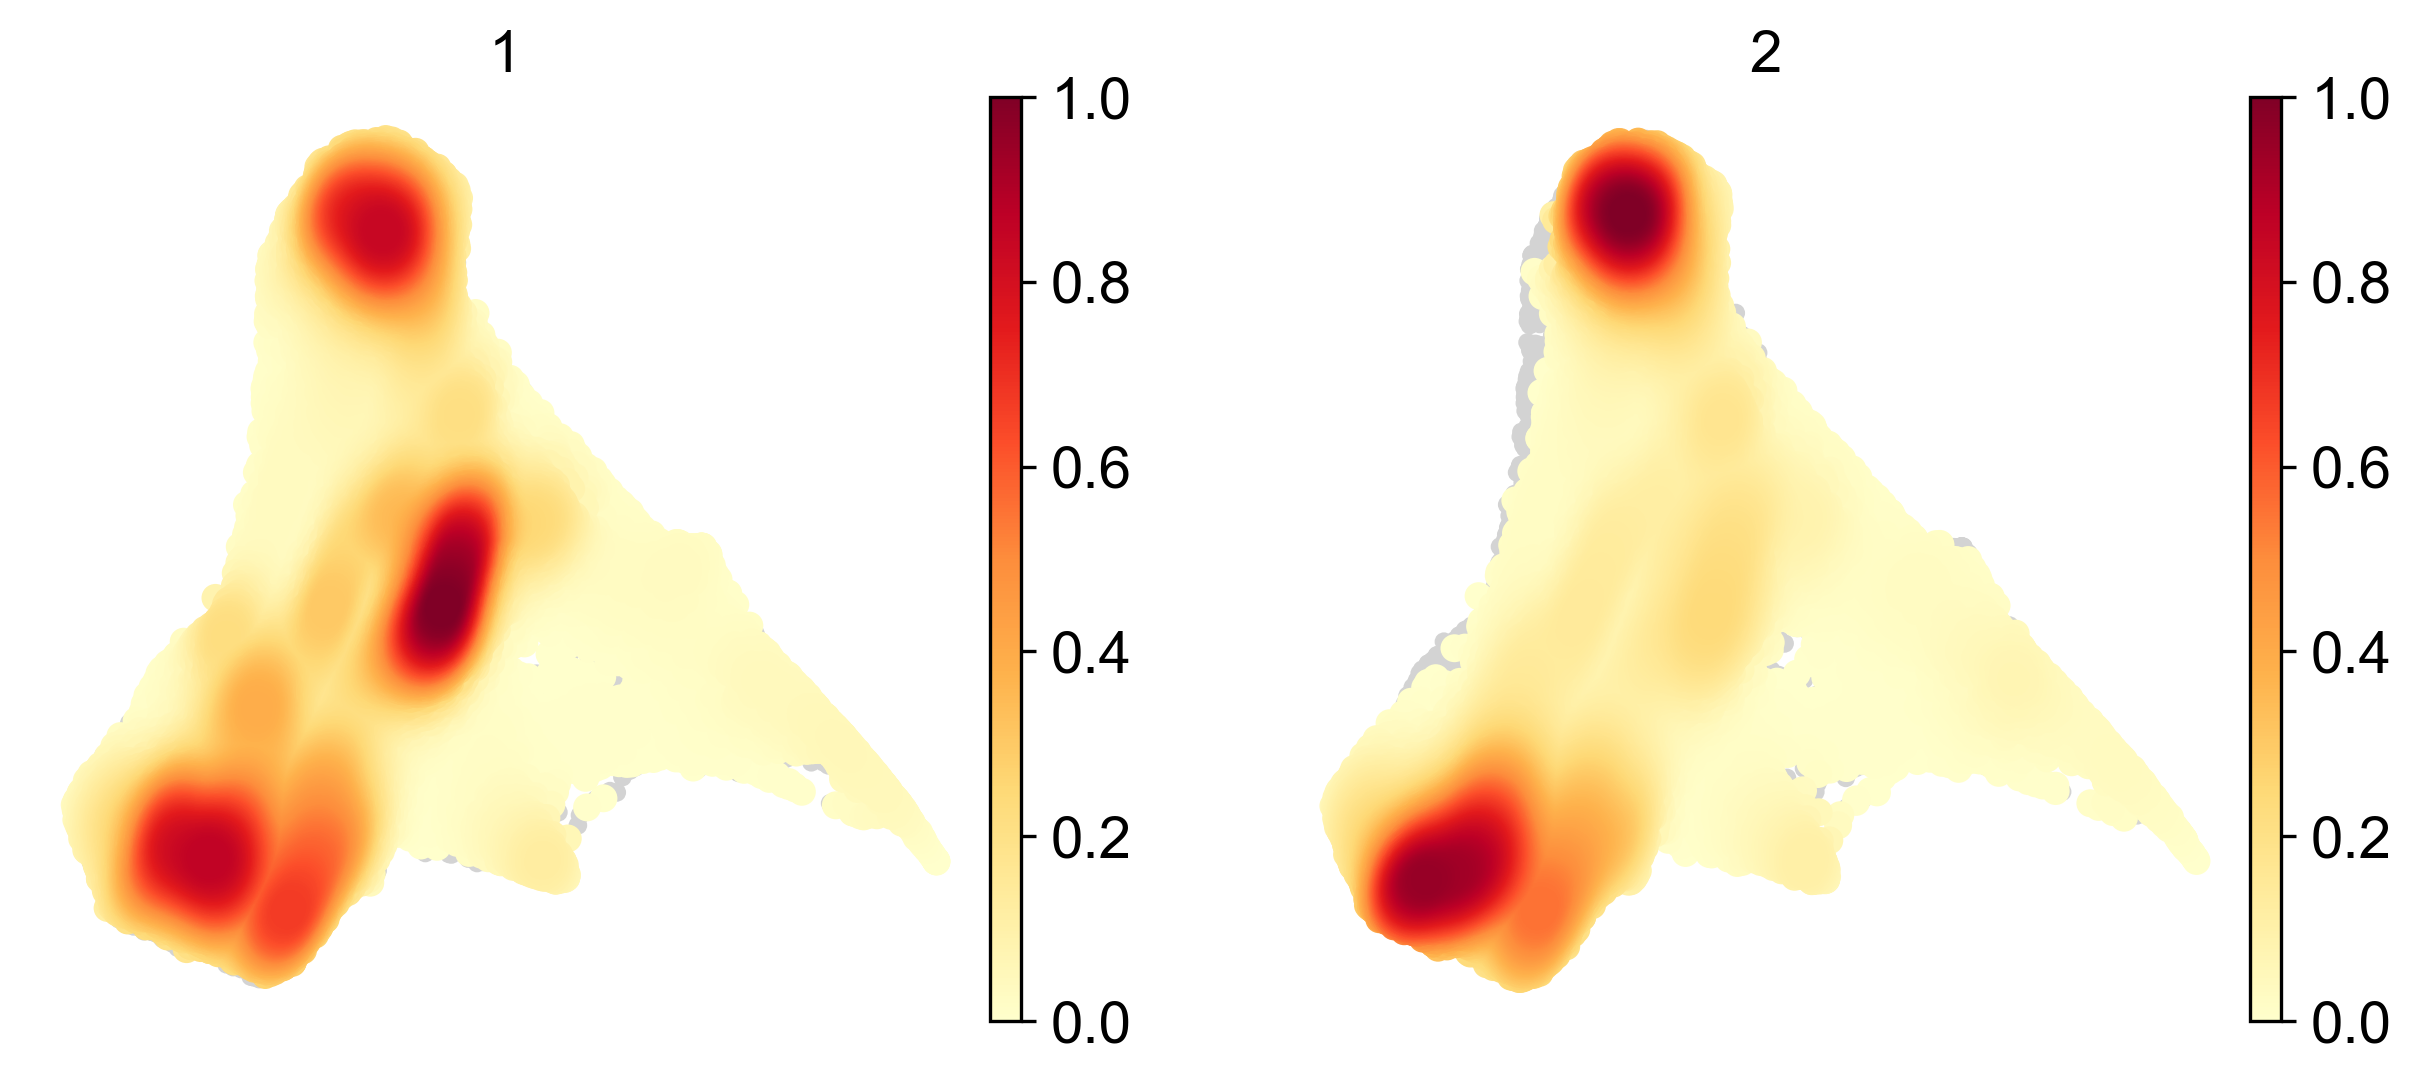

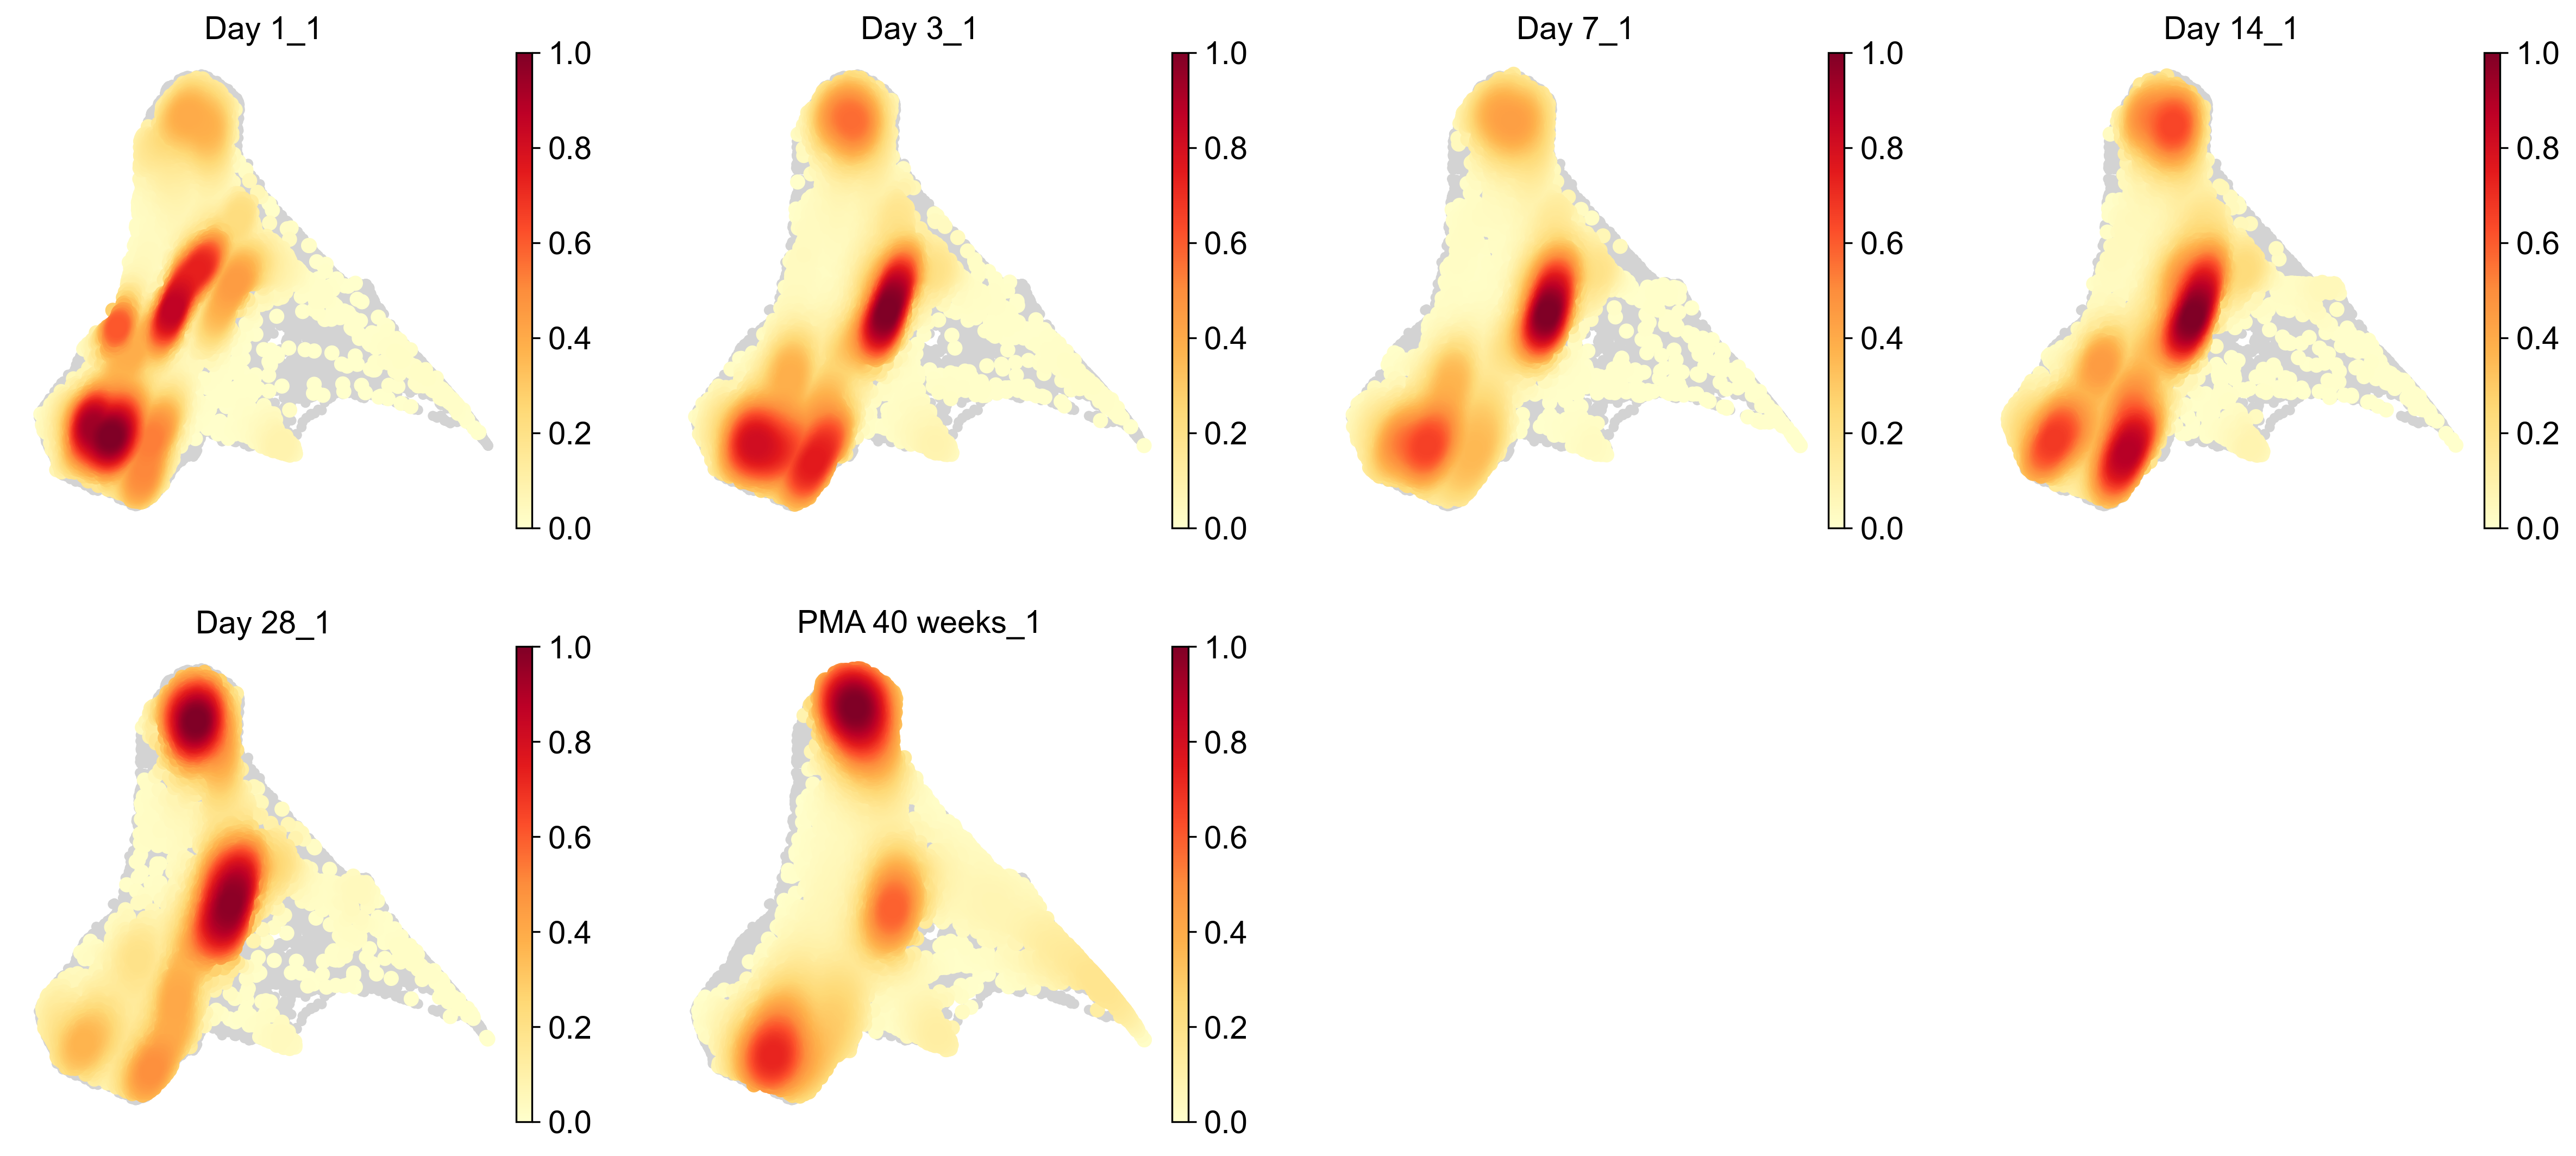

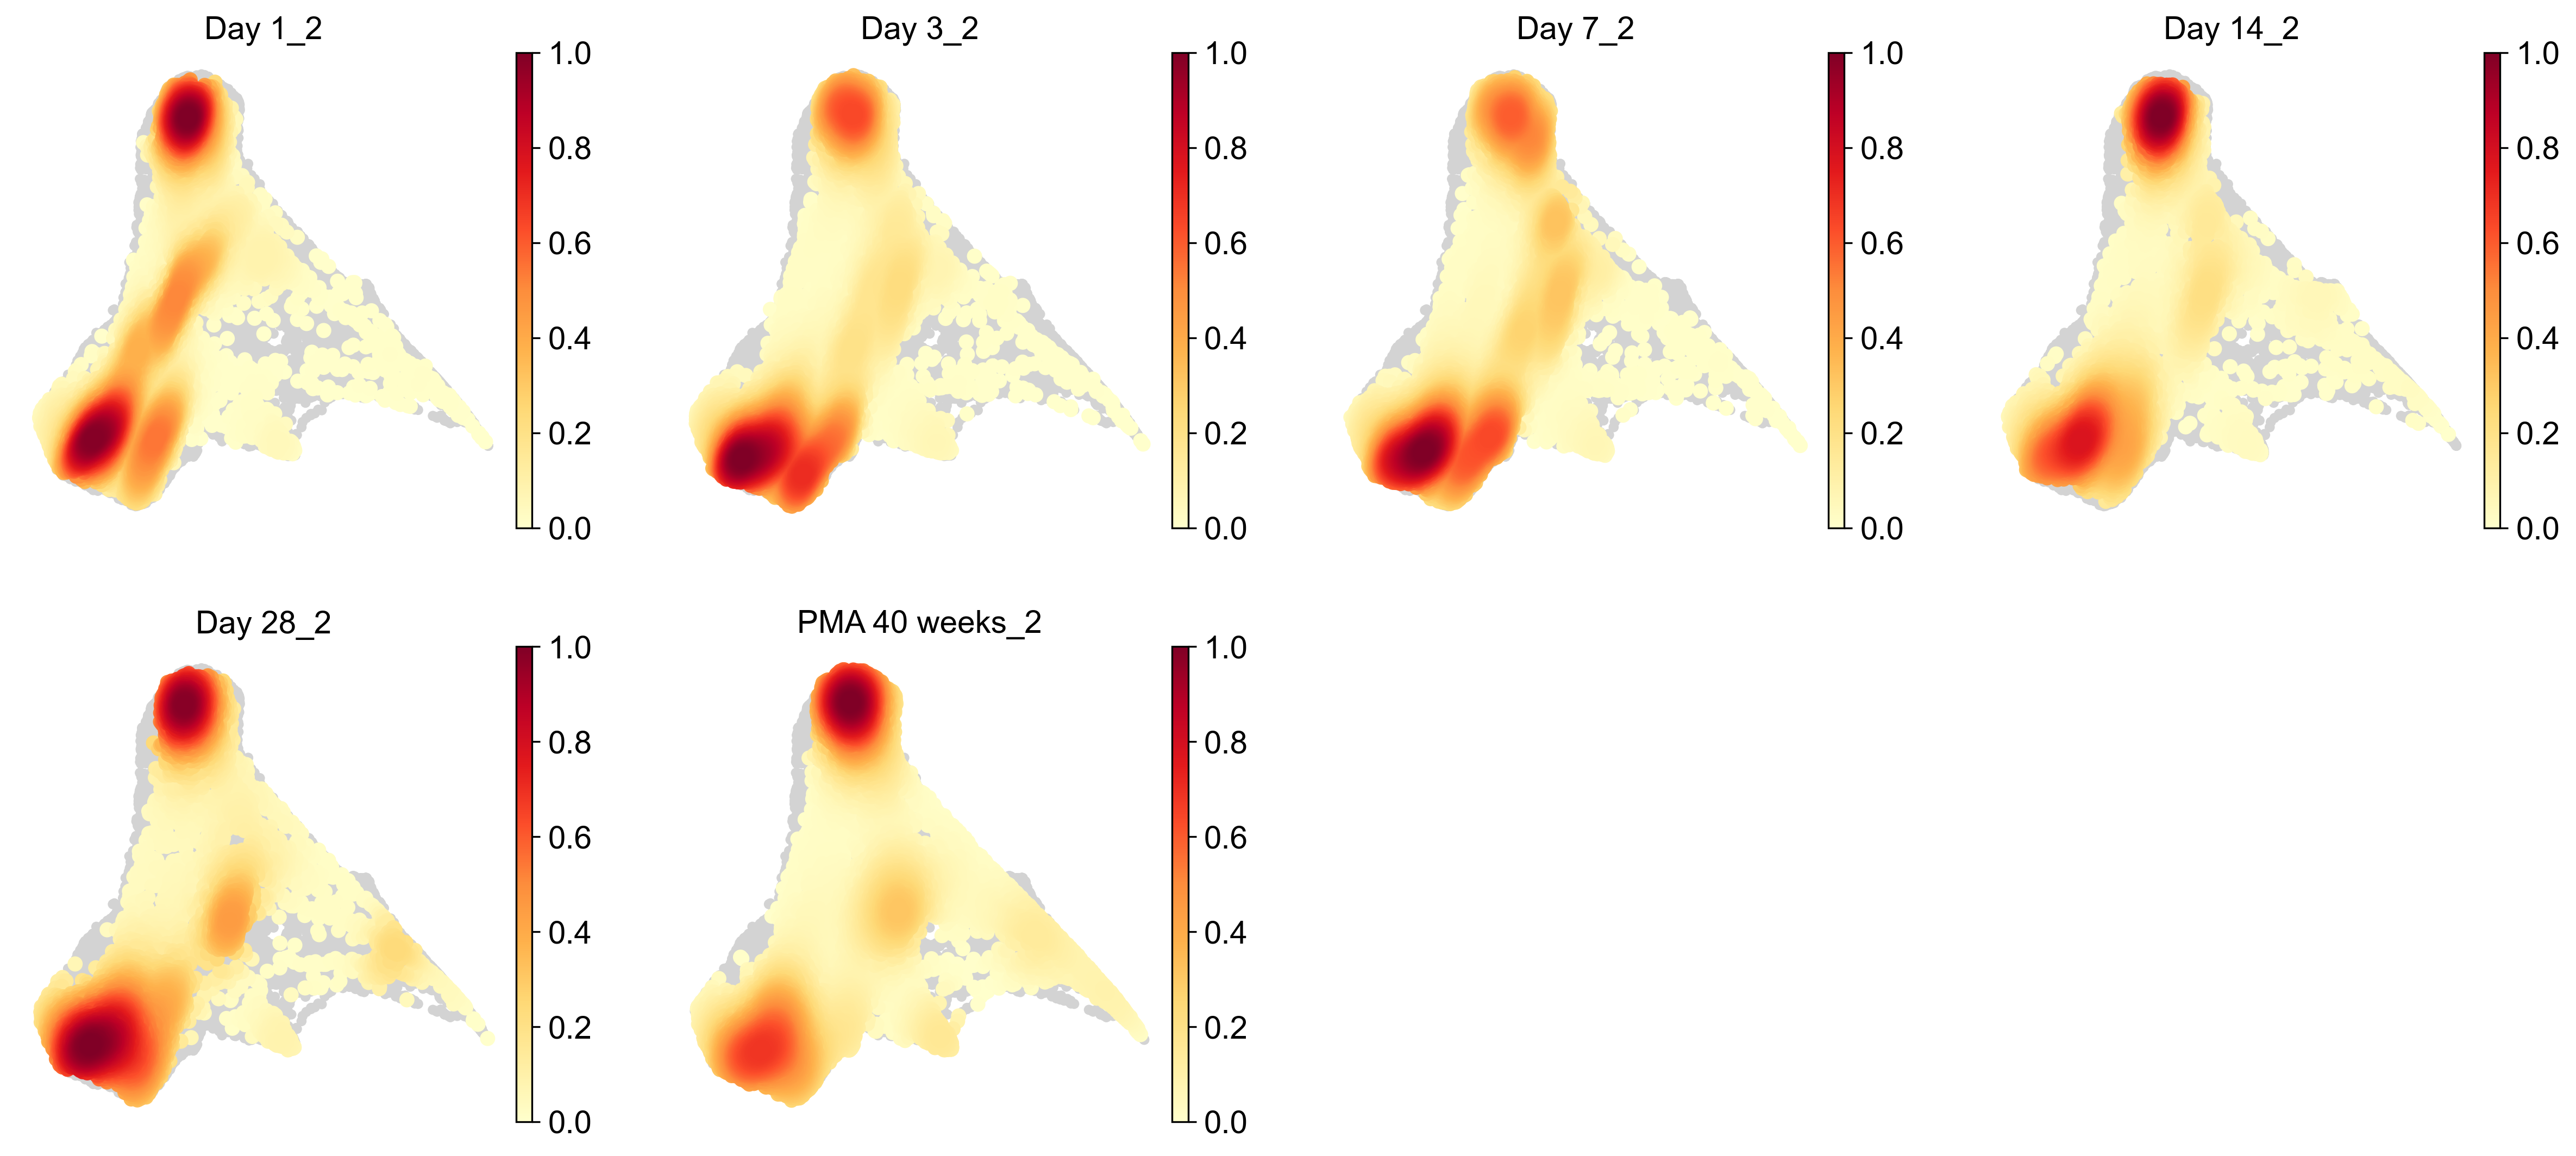

In [4]:
# save figures to a sub dir
figpath='./figures/' + sub_name + '/'
os.makedirs(figpath, exist_ok=True)
sc.settings.figdir=figpath

n_comps = min([adata.n_obs, adata.n_vars, 21])-1
sc.tl.pca(adata, svd_solver='arpack', n_comps=n_comps)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_comps)
    
# paga process
sc.tl.leiden(adata, resolution=0.3) 

sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=['leiden'], threshold=0.1, show=False, 
           save='_' + sub_name + '.pdf')

sc.tl.draw_graph(adata, init_pos='paga')

sc.pl.draw_graph(adata, color=['timepoint', 'group', 'leiden', 'batch'], show=False,
                 save='_' + sub_name + '.pdf')
    
sc.pl.draw_graph(adata, color=adata.var.index.values, show=False,
                 save='_' + sub_name + '_markers.pdf')

sc.tl.embedding_density(adata, basis='draw_graph_fa', groupby='group')
sc.pl.embedding_density(adata, basis='draw_graph_fa', key='draw_graph_fa_density_group', 
                        group=['1', '2'],
                        save='_' + sub_name + '_group_density.pdf')
sc.tl.embedding_density(adata, basis='draw_graph_fa', groupby='timepoint_group')
sc.pl.embedding_density(adata, basis='draw_graph_fa', key='draw_graph_fa_density_timepoint_group', 
                        group=['Day 1_1', 'Day 3_1', 'Day 7_1', 'Day 14_1', 'Day 28_1', 'PMA 40 weeks_1'],
                        save='_' + sub_name + '_timepoint_group1_density.pdf')
sc.pl.embedding_density(adata, basis='draw_graph_fa', key='draw_graph_fa_density_timepoint_group', 
                        group=['Day 1_2', 'Day 3_2', 'Day 7_2', 'Day 14_2', 'Day 28_2', 'PMA 40 weeks_2'],
                        save='_' + sub_name + '_timepoint_group2_density.pdf')
    

In [5]:
os.makedirs('PAGA_result_data/', exist_ok=True)
adata.write(filename='PAGA_result_data/all_' + sub_name + '_sample1000.h5ad', compression = 'gzip')